# Boundary Condition for the Unsaturated Zone in a Polder Domain

We create three simulations for a polder domain with length $L$ and height $D$. At the top boundary of the polder domain there is a constant infiltration flux of 1mm/d. At both sides of the there are two canals which are represented by a constant head boundary. Above this constant head boundary it is difficult to choose a boundary condition. It is part of the unsaturated zone so a seepage face would be most fitting. However one could also choose for a no flow boundary or constant head (negative pressure head above soil).

![Perceel](Perceel.png)
*Figure 1: Half $\left(\frac{1}{2} L \right)$ a polder domain which is also what is modelled for symmetry reasons*

To choose the correct boundary condition for the unsaturated zone, we do a simulation with three boundary conditions: one with a constant head along the entire (left) boundary, one with a constant head (for the saturated zone) and above a no flow boundary (for the unsaturated zone), and one with a seepage face (unsaturated zone) above the no constant head boundary (saturated zone). 

Note: I know this simulation could be done with one stress period in the future I'll quickly wan't to start varying recharge during the timesteps.

## Python packages

In [1]:
# packages
import vs2dpy as vd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm

%matplotlib inline

## Simulation parameters

In [2]:
recharge = 1e-3 # mm / d

nlay = 100 # no. of layer cells
ncol = 50 # no. of colum cells
nrow = 1 # no. of row cells

height = 10 # m
length = 100.0 / 2 # m
shead = 7.5 # starting head in m
layers = np.linspace(height, 0, nlay+1)

nper = 500 # periods
tmax = nper # days
perlen = 1 # d
nstp = 1 # steps per day

# elevation of vs2d nodes (to from pressure head to head)
Y = np.reshape(layers[:-1] + np.diff(layers)/2, (nlay,1))
X = np.arange(0, length, length/ncol)
XY = np.meshgrid(X, Y)
elev = np.full((nlay, ncol), fill_value=Y)

VS2DRTI uses van full van Genuchten parameters. I created a seperate pedotransfer class in VS2DPY which returns the right parameter set based on the sand percentage, silt percentage, clay percentage (and optionally density).

In [3]:
# van genuchten parameters
sand = 50 # sand percentage
silt = 30 # silt percentage
clay = 20 # clay percentage
d = 1.2 # density g/cm3

# create pedotransfer class
ptf = vd.utils.ptf(sand=sand, silt=silt, clay=clay)

# get parameters for VS2D
sp = ptf.pedotransfer_vg(d=d)
soilpar = sp.to_frame("SoilPar_VS2D").astype(float)
soilpar

,SoilPar_VS2D
theta_r,0.089099
theta_s,0.455989
ks [cm/d],5.362543
alpha [1/cm],0.126733
n,1.164671
l,0.500000


## Some functions to create models and visualize results

In [4]:
def create_vs2drti_model(modelname:str, no_flow_option:bool = False, seepage_face:bool = False, add_aquitard:bool = False):
    
    # create model
    ml = vd.Model(titl=modelname, ws=f"seepage_test/{modelname}", tmax=tmax, tunit="day")
    
    # node below head
    labove = sum(layers>shead)

    # define model output and stress periods (called recharge periods in VS2D)
    ml.define_output(nrech=nper, numt=1000000, f6p=True, prnt=True, nplt=nper, pltim=np.arange(1., nper+1))

    # define domain
    # pad with one ghost node 
    dxr = np.full((ncol+2), length / (ncol))
    delz = np.full((nlay+2), height / (nlay))
    ml.define_domain(
        nxr=ncol+2,
        nly=nlay+2,
        dxr=dxr,
        delz=delz,
    )

    # define solver
    ml.define_solver(delt=0.01, eps=0.001, itmax=1000, dltmx=0.5)
    
    # define soil properties
    soilprop = [
        1.0, # anisitropy
        soilpar.loc["ks [cm/d]", "SoilPar_VS2D"] / 1e2, # saturated conductivity
        0.001, # specific storage
        soilpar.loc["theta_s", "SoilPar_VS2D"],
        soilpar.loc["alpha [1/cm]", "SoilPar_VS2D"] * 1e2,
        soilpar.loc["theta_r", "SoilPar_VS2D"],
        soilpar.loc["n", "SoilPar_VS2D"],
    ]
    textures = {1: np.array([1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]),
                2: np.array(soilprop)}
    jtex = np.full((nlay, ncol), 2)

    if add_aquitard:
        soilprop3 = [
            1.0, # anisitropy
            soilpar.loc["ks [cm/d]", "SoilPar_VS2D"] / 1e6, # saturated conductivity
            0.001, # specific storage
            soilpar.loc["theta_s", "SoilPar_VS2D"],
            soilpar.loc["alpha [1/cm]", "SoilPar_VS2D"] * 1e2,
            soilpar.loc["theta_r", "SoilPar_VS2D"],
            soilpar.loc["n", "SoilPar_VS2D"],
        ]
        textures[3] = np.array(soilprop3)
        jtex[labove, :] = 3
    
    jtex = np.pad(jtex, pad_width=1, constant_values=1, mode="constant")
    ml.define_soil(ntex=len(textures), textures=textures, jtex=jtex)

    # define starting conditions
    starthead = height-shead
    ml.define_initialc(iread=2, dwtx=starthead, hmin=-starthead)
   
    # define boundary conditions

    # seepage face
    seepf = {}
    nfcs = 1
    for i in range(nfcs):
        seepf[f"jj_{i}"] = labove
        seepf[f"jlast_{i}"] = 0
        seepf[f"jspx_{i}"] = [(x+2, 2) for x in reversed(range(labove))]
    
    # boundary conditions in each node
    ntx = []
    # (J, N, NTX, PFDUM)
    if no_flow_option: 
        for row in np.arange(labove, nlay): # only provide head for nodes along boundary below starting head
            ntx.append([row+2, 2, 4, -starthead])
    elif seepage_face: 
        for row in np.arange(labove): # only provide seepage face for nodes along boundary above starting head
            ntx.append([row+2, 2, 3, 0.0])
        for row in np.arange(labove, nlay): # only provide head for nodes along boundary below starting head
            ntx.append([row+2, 2, 4, -starthead])
    else:
        for row in range(nlay): # provide head along entire boundary
            ntx.append([row+2, 2, 4, -starthead])

    for col in range(ncol-1): # recharge boundary
        ntx.append([2, col+3, 2, recharge])


    bc = {}
    for i in range(ml.nrech):
        bc[i+1] = ml.create_bc(pond=0.0, ntx=np.array(ntx), seep=seepage_face, nfcs=nfcs, seepf=seepf)

    ml.define_rp(tper=np.arange(1, ml.nrech+1), bc=bc)
    return ml

In [5]:
# get head vs2d
def get_phead_vs2d(ml, timestep:int=0):
    ho = ml.read_var_out()
    t_search = timestep+1.
    times = ho.times
    # get nearest time if printing times did not work correctly
    if t_search in times:
        idx = times.index(t_search)
    else:
        idx = np.argmin(np.abs(np.array(times)-t_search))
        print(f"Timestep miracoulously not in VS2D variables.out file, using time {times[idx]} instad")
    heads = ho.get_data(timesteps=idx)[0, 1:-1, 1:-1]
    return heads

# plot pressure head
def plot_pheads(models:list, XY:np.ndarray, timestep:int=0, levels:np.ndarray=np.arange(-5, shead+2), add_clabel=True, figsize:tuple=(16,6), ax=None):
    
    #Create figure with names "M1", "M2", "M3" for model 1, 2, 3
    mosaic = [[f"M{x+1}" for x in range(len(models))]]
    if ax is None:
        _, ax = plt.subplot_mosaic(mosaic, figsize=figsize, sharey=True)   

    for i, x in enumerate(ax):
        ml = models[i] # get the first model
        
        # get head if VS2D model
        heads = get_phead_vs2d(ml, timestep)
        name = ml.titl
        
        # make contour plot of pressure head
        cp = ax[x].contour(XY[0], XY[1], heads, levels=levels)
        if add_clabel:
            ax[x].clabel(cp)
        ax[x].set_title(f"{timestep=} d\n{name}")
        ax[x].grid()
        ax[x].set_yticks(np.arange(0, height+1, 1))
    
    return ax

In [6]:
# some simulation settings
silent = True
solve = True

# Constant Head along Boundary
The first model with a constant head boundary on the left hand side for both the saturated and unstaturated zone.

In [7]:
# VS2DRTI Model with Constant Head along Boundary
ml3_ch = create_vs2drti_model("01_chead_vs2d", no_flow_option=False)
if solve:
    ml3_ch.write_input()
    ml3_ch.run_model(silent=silent);
else:
    ml3_ch.read(f"{ml3_ch.ws}/vs2drt.dat")

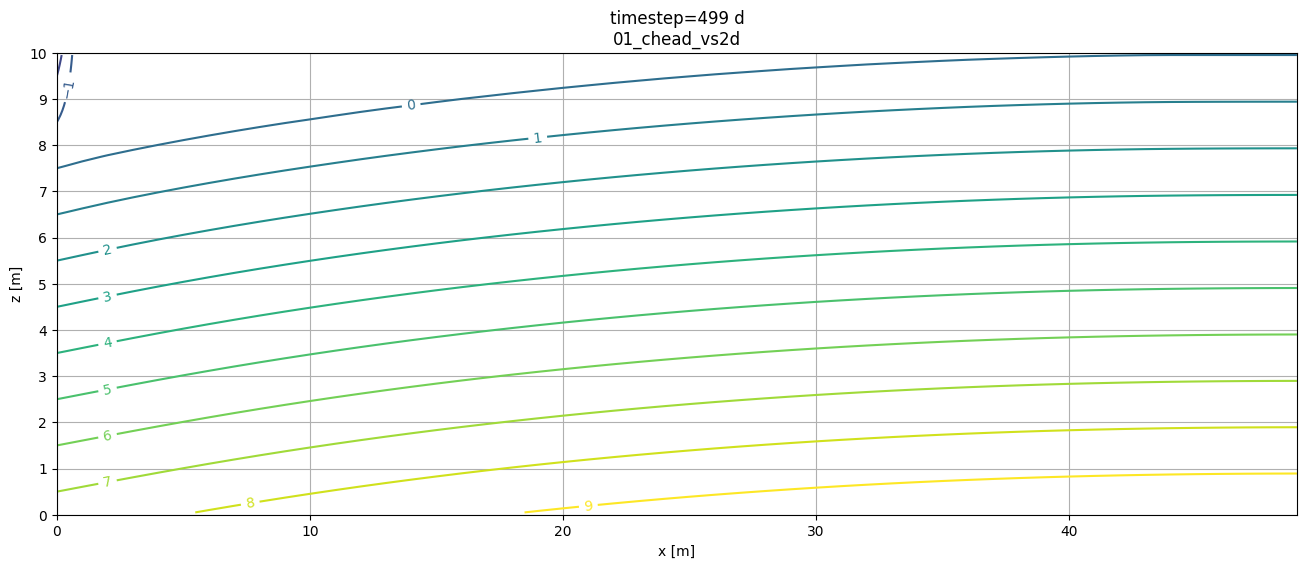

In [8]:
ax = plot_pheads([ml3_ch], XY, timestep=499)
[ax[x].set_xlabel("x [m]") for x in ax]
ax["M1"].set_ylabel("z [m]");

*Figure 2: Pressure head for three unsaturated zone models. Two modflow-USG models, one with iBound = -1 (subplot 1) and one with constant head package (subplot 2) along left side boundary. The other model is VS2D (subplot 3).*

We can see that there is a slight difference between the MODFLOW-USG models. The CHD package seems to keep the head constant at the boundary, while the ibound=-1 for the left boundary does not work for the unsaturated zone. Compared to VS2D, the models do differ because the pressure head is larger in VS2D. The difference can (partially) be explained by the difference in function for the hydraulic conductivity. VS2D uses the van Genuchten equation for the hydraulic conductivity function while MODFLOW-USG uses Brooks-Corey. 

# No Flow Along Top Boundary

In [9]:
# VS2DRTI Model with Constant Head along Boundary set with ibound and above no flow boundary
ml3_nf = create_vs2drti_model("02_noflow_vs2d", no_flow_option=True)
if solve:
    ml3_nf.write_input()
    ml3_nf.run_model(silent=silent);
else:
    ml3_nf.read(f"{ml3_nf.ws}/vs2drt.dat")

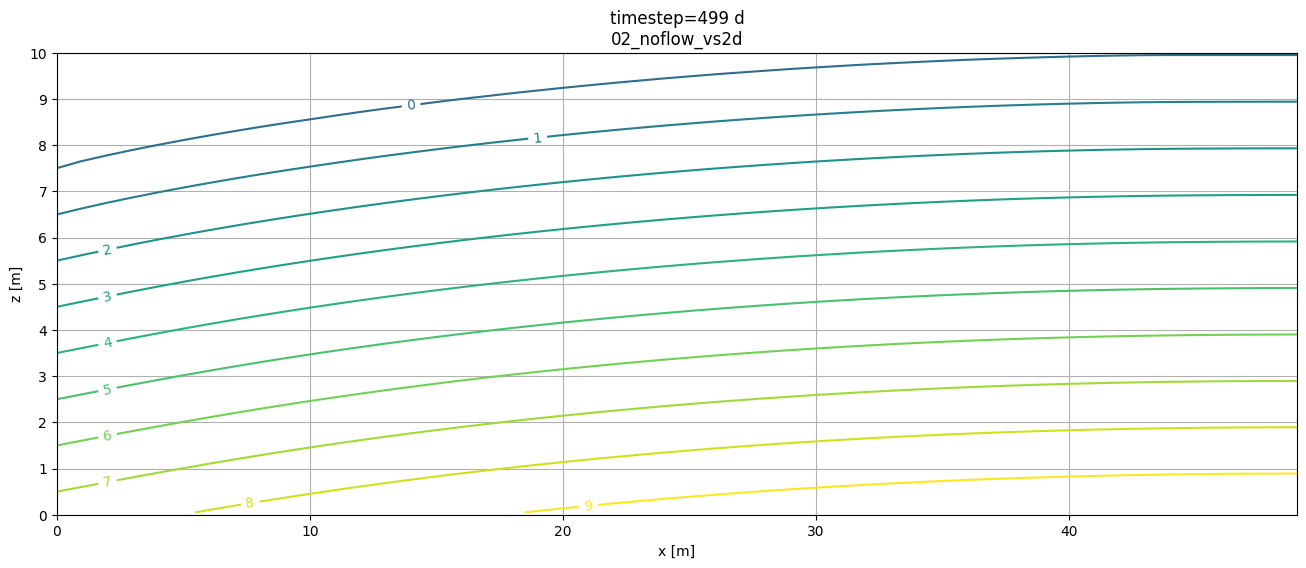

In [10]:
ax = plot_pheads([ml3_nf], XY, timestep=499)
[ax[x].set_xlabel("x [m]") for x in ax]
ax["M1"].set_ylabel("z [m]");

*Figure 3: Pressure head for three unsaturated zone models. Two modflow-USG models, one with iBound = -1 (subplot 1) and one with constant head package (subplot 2) along left side boundary. The other model is VS2D (subplot 3). However the constant boundary conditions is only valid for the saturated zone, for the unsaturated zone (z > 7.5 m) there is a no flow boundary.*

For this simulation, there is no difference between the MODFLOW-USG models. Also the VS2D mdoel is not that different.

# Seepage Face

To see the effect of a seepage face boundary we use three VS2D models. 

A seepage face boundary functions acts as a no-flow boundary when the soil is unstaturated. When the soil does become saturated, water can start flowing out of the model domain.

To allow the saturated zone to actually reach the seepage face, we add an aquitard at z=4 m with a factor 1000 less for the hydraulic condictivity.

In [11]:
add_aquitard = False

# update parameters so simulation does not take forever
nlay = 50 # no. of layer cells
height = 5 # m
shead = 4 # starting head in m
layers = np.linspace(height, 0, nlay+1)
Y = np.reshape(layers[:-1] + np.diff(layers)/2, (nlay,1))
X = np.arange(0, length, length/ncol)
XY = np.meshgrid(X, Y)

nper = 100 # periods
tmax = nper # days

ml3_ch_aqt = create_vs2drti_model("03_chead_aqt_vs2d", add_aquitard=add_aquitard)
if solve:
    ml3_ch_aqt.write_input()
    ml3_ch_aqt.run_model(silent=silent);
else:
    ml3_ch_aqt.read(f"{ml3_ch_aqt.ws}/vs2drt.dat")

ml3_nf_aqt = create_vs2drti_model("03_noflow_aqt_vs2d", no_flow_option=True, add_aquitard=add_aquitard)
if solve:
    ml3_nf_aqt.write_input()
    ml3_nf_aqt.run_model(silent=silent);
else:
    ml3_nf_aqt.read(f"{ml3_nf_aqt.ws}/vs2drt.dat")

ml3_sf_aqt = create_vs2drti_model("03_seep_aqt_vs2d", seepage_face=True, add_aquitard=add_aquitard)
if solve:
    ml3_sf_aqt.write_input()
    ml3_sf_aqt.run_model(silent=silent);
else:
    ml3_sf_aqt.read(f"{ml3_sf_aqt.ws}/vs2drt.dat")

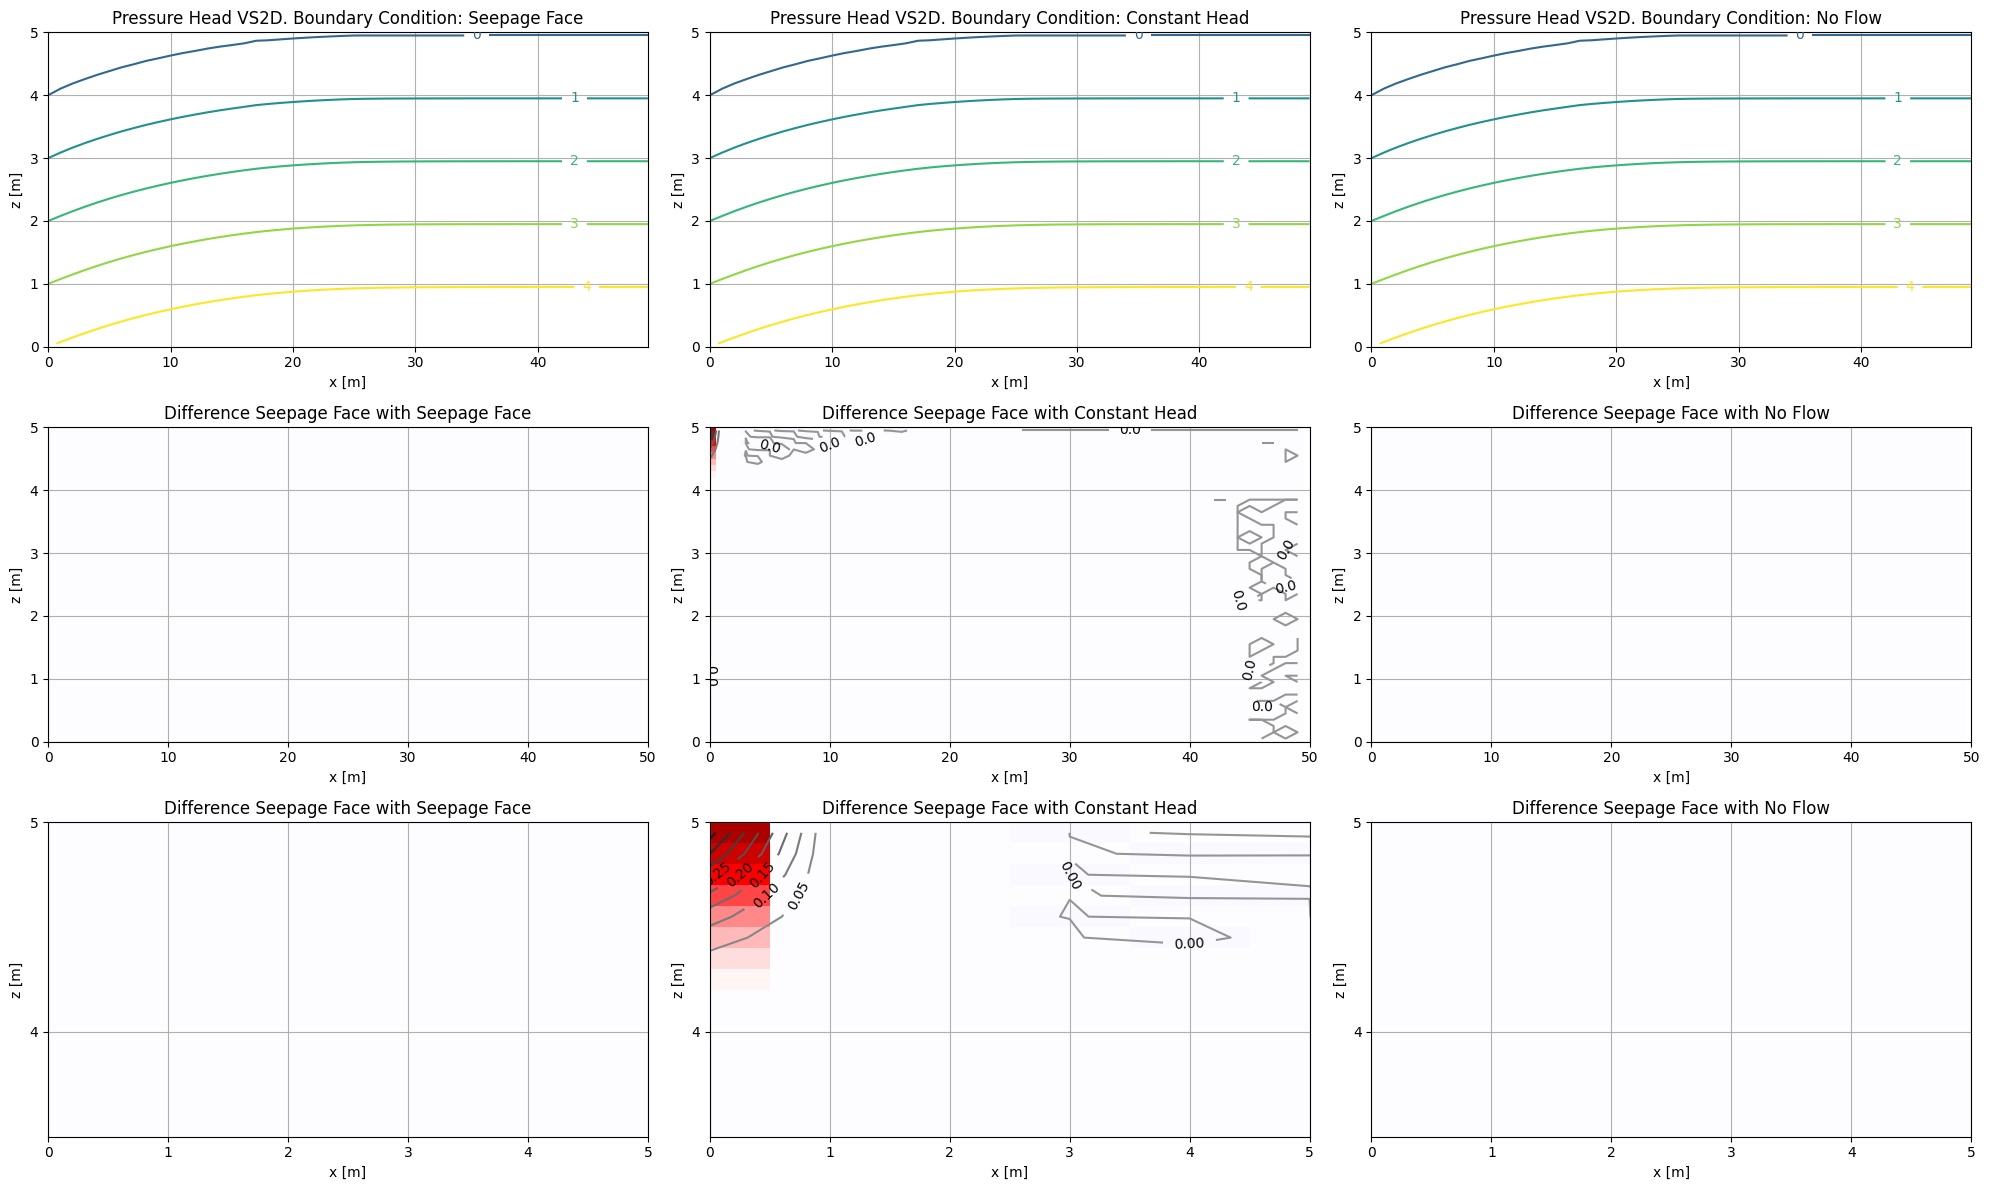

In [12]:
timestep = 99
levels = np.arange(-2, shead+1)
diff = 0.5
f, ax = plt.subplot_mosaic([["M1", "M2", "M3"], ["D1", "D2", "D3"], ["Dz1", "Dz2", "Dz3"]], figsize=(20,12))
h_sf = get_phead_vs2d(ml3_sf_aqt, timestep)
h_ch = get_phead_vs2d(ml3_ch_aqt, timestep)
h_nf = get_phead_vs2d(ml3_nf_aqt, timestep)

names = ["Seepage Face", "Constant Head", "No Flow"]
for i, h in enumerate((h_sf, h_ch, h_nf), start=1):
    cp = ax[f"M{i}"].contour(XY[0], XY[1], h, levels=levels)
    ax[f"M{i}"].clabel(cp)
    ax[f"M{i}"].set_title(f"Pressure Head VS2D. Boundary Condition: {names[i-1]}")
    ax[f"M{i}"].set_xlabel("x [m]")
    ax[f"M{i}"].set_ylabel("z [m]")
    ax[f"M{i}"].grid()
    ax[f"M{i}"].set_yticks(np.arange(0, height+1, 1))

    d = h_sf - h
    ax[f"D{i}"].set_title(f"Difference Seepage Face with {names[i-1]}")
    ax[f"D{i}"].set_xlim(0, 50)
    ax[f"D{i}"].set_yticks(np.arange(0, height+1, 1))
    # ax[f"D{i}"].contourf(XY[0], XY[1], d, levels=np.linspace(-diff, diff, 10), cmap="seismic")
    ax[f"D{i}"].pcolormesh(XY[0], XY[1], d, norm=BoundaryNorm(np.linspace(-diff, diff, 255), ncolors=255), cmap="seismic")
    cp = ax[f"D{i}"].contour(XY[0], XY[1], d, levels=np.linspace(-diff, diff, 11), cmap="Greys")
    ax[f"D{i}"].clabel(cp, colors="k")
    ax[f"D{i}"].grid()
    ax[f"D{i}"].set_xlabel("x [m]")
    ax[f"D{i}"].set_ylabel("z [m]")

    ax[f"Dz{i}"].set_title(f"Difference Seepage Face with {names[i-1]}")
    ax[f"Dz{i}"].set_xlim(0, 5)
    ax[f"Dz{i}"].set_yticks(np.arange(0, height+1, 1))
    ax[f"Dz{i}"].set_ylim(3.5, height)
    # ax[f"D{i}"].contourf(XY[0], XY[1], d, levels=np.linspace(-diff, diff, 10), cmap="seismic")
    ax[f"Dz{i}"].pcolormesh(XY[0], XY[1], d, norm=BoundaryNorm(np.linspace(-diff, diff, 255), ncolors=255), cmap="seismic")
    cp = ax[f"Dz{i}"].contour(XY[0], XY[1], d, levels=np.linspace(-diff, diff, 21), cmap="Greys")
    ax[f"Dz{i}"].clabel(cp, colors="k")
    ax[f"Dz{i}"].grid()
    ax[f"Dz{i}"].set_xlabel("x [m]")
    ax[f"Dz{i}"].set_ylabel("z [m]")

f.tight_layout()

*Figure 4*

Please note that the xlim and ylim of the bottom subplots is different than the upper subplots.

We do see small differences along the unsatrated zone boundary. The constant head boundary is significantly dryer than the seepage face. This can nodes at this boundary are forced to be less saturated. Additionaly, water is allowed to flow out of the domain, even if the soil is not saturated. So this means that the amount of water will be underestimated compared to a seepage face, Most of the effect dissappears within 1 m of the boundary which is 1% of L.

On the right hand side the difference is visible with the no flow boundary. There the effects are both larger and are visible further into the domain (up to 5m, 5% of L). Water can't flow through the boundary thus water ponds more easily and the upper part of the domain gets wetter.
